# Page average entanglement formula numerical verification
Page (1994) conjectured that the haar averaged bipartitle entanglement of a pure state $\rho_{AB}$ is given by

$$S_{m,n} = \sum_{k=n+1}^{mn}\frac{1}{k} - \frac{m-1}{2n}$$
where $m\leq n$ is the subsystem Hilbert space dimension. For example, a partition of $k_1$ and $k_2$ qubit will give $m=2^{k_1}, n=2^{k_2}$ as Hilbert space dimension. This is later proven by various people

We try to verify the formula by doing Monte Carlo. We will do an inefficient method of sampling directly from $U(N)$. The algorithm is taken from the link https://pennylane.ai/qml/demos/tutorial_haar_measure/#deguise2018

## Two-dimensional Haar sampling

In [37]:
import numpy as np
from numpy.linalg import qr
import matplotlib.pyplot as plt

def qr_haar(N):
    A, B = np.random.normal(size=(N,N)), np.random.normal(size=(N,N))
    Z = A+1.j*B
    Q,R = qr(Z)
    #Lambda = np.diag(R)
    #Lambda = Lambda/np.abs(Lambda)
    Lambda = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(N)])
    return np.dot(Q,Lambda)

In [13]:
qr_haar(2)

array([[-0.03350609-0.9704777j ,  0.0364481 -0.2360549j ],
       [-0.20708314+0.11902501j,  0.91740874-0.31829361j]])

In [32]:
def bloch_params(state):
    gPhase = state[0]/np.abs(state[0])
    state /= gPhase
    theta = 2*np.arccos(np.real(state[0]))
    ePhi = state[1]/np.sin(theta/2)
    phi = np.arctan2(np.imag(ePhi),np.real(ePhi))
    return theta, phi

In [59]:
bloch_samples = np.array([bloch_params(qr_haar(2)[0]) for i in range(500)])

In [60]:
z = np.cos(bloch_samples[:,0])
x = np.sin(bloch_samples[:,0])*np.cos(bloch_samples[:,1])
y = np.sin(bloch_samples[:,0])*np.sin(bloch_samples[:,1])

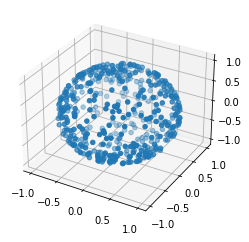

In [66]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, marker='o')

In [47]:
np.min(bloch_samples[:,0])

0.034982905430083776

## Calculating entanglement entropy by sampling
We will take the first row of the Haar unitary generated with $N=2^{m+n}$ and reshape the matrix into $2^m \times 2^n$ and do SVD, computing the entanglement entropy by Schmidt decomposition

In [80]:
def _sample_entanglement_entropy(N,m,n):
    assert m+n == N, "The dimension must add up"
    assert m<=n, "The first partition is smaller than second"
    state = qr_haar(2**N)[0]
    state = state.reshape(2**m,2**n)
    _,Lambda,_ = np.linalg.svd(state)
    sval = Lambda**2
    return np.sum(-sval*np.log(sval))

In [89]:
def sample_entanglement_entropy(N,m,n,nsample):
    return np.array([_sample_entanglement_entropy(N,m,n) for i in range(nsample)])

In [103]:
def page_formula(m,n):
    return np.sum(1/np.arange(n+1,m*n+1)) - (m-1)/(2*n)
    

In [100]:
nsamples = 1000
N = 6
samples = {}
i = 1
while i <= N/2:
    samples[f'({N},{i},{nsamples})'] = sample_entanglement_entropy(N,i,N-i,nsamples)
    i += 1

In [101]:
[np.mean(samples['(6,1,1000)']),np.mean(samples['(6,2,1000)']),np.mean(samples['(6,3,1000)'])]

[0.669540080547475, 1.2696593687027058, 1.5858210398873052]

In [108]:
[page_formula(2**i,2**6/2**i) for i in range(1,4)]  # The total hilbert space is 2^6 dimension, the partition of i qubit to the left give m = 2^i, and n = 2^(6-i)

[0.6697707082692489, 1.2694119104767758, 1.5885337608486263]

Note that they agree pretty well

## Verification for different number of qubits up to $N=7$

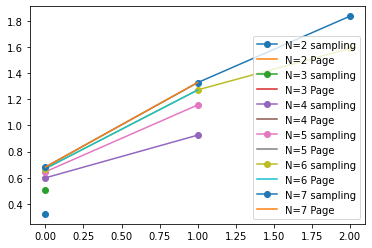

In [112]:
nsamples = 1000
N = 7
for n in range(2,N+1):
    sresult = []
    i = 1
    while i <= n/2:
        sresult.append(np.mean(sample_entanglement_entropy(n,i,n-i,nsamples)))
        i += 1
    sresult = np.array(sresult)
    presult = np.array([page_formula(2**i,2**(n-i)) for i in range(1,int(n/2))])
    plt.plot(sresult,marker='o',label=f'N={n} sampling')
    plt.plot(presult,label=f'N={n} Page')
plt.legend()

## Question
1. What exactly is the measure Page is integrating on? Are there reference on how the formula pop up?